In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import datetime
import sys
import re
import gc
import glob

import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from utils import logger_func, get_categorical_features, get_numeric_features, pararell_process
logger = logger_func()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

#========================================================================
# Global Variable
#========================================================================

2018-11-27 07:55:01,455 utils 366 [INFO]    [logger_func] start 


In [2]:
# DatasetのPickle化
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')
# utils.to_df_pkl(df=train, path='../input', fname='train')
# utils.to_df_pkl(df=test, path='../input', fname='test')
train = utils.read_df_pkl(path='../input/train*.p')
test = utils.read_df_pkl(path='../input/test*.p')

100%|██████████| 3/3 [00:00<00:00, 94.16it/s]


In [3]:
print(train.shape)
print(test.shape)

(1306122, 3)
(56370, 2)


In [4]:
import json
import string
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from wordcloud import WordCloud, STOPWORDS

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



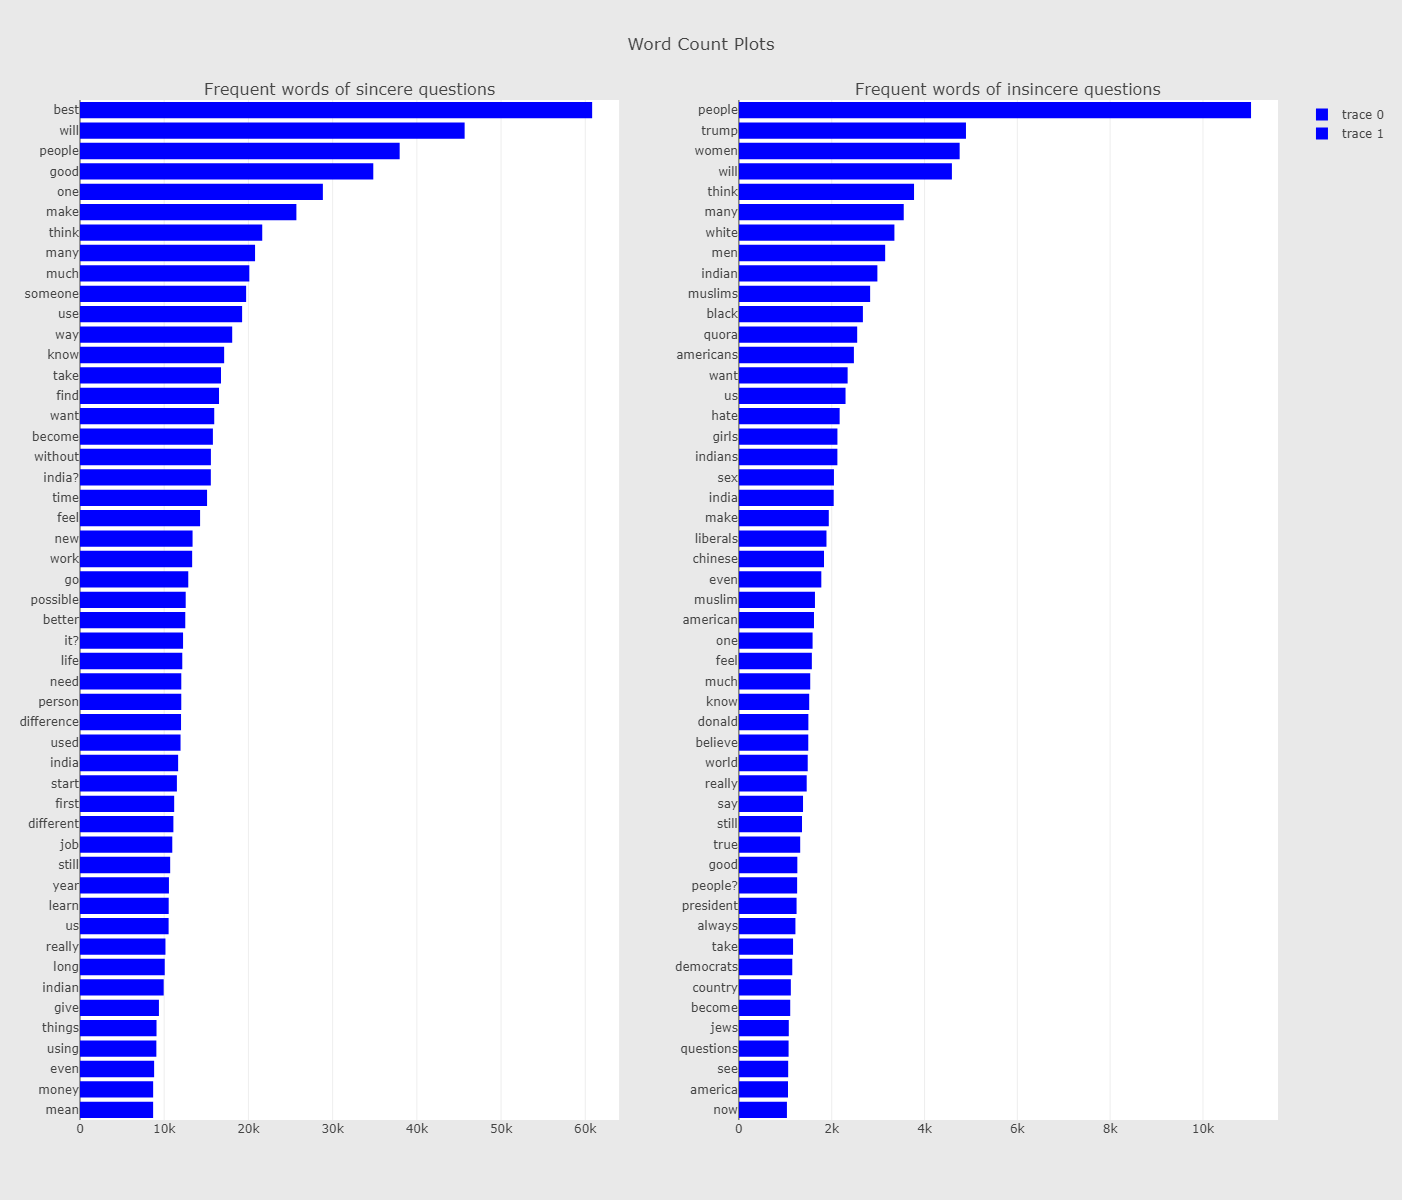

In [72]:
from collections import defaultdict
train_1 = train[train["target"]==1]
train_0 = train[train["target"]==0]


## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    # *はリストを解除する.ここでは単語単位でリストに格納されており、
    # n_gramの数に応じて最初のインデックスが変わっていくので、1つずつインデックスのズレたリストがzipに入り、
    # n_gramの作成になっている
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(color=color,),
    )
    return trace


## Get the bar chart from sincere question ##
# n_gramの単位でワードカウント
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]        
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                         subplot_titles=["Frequent words of sincere questions",
                                         "Frequent words of insincere questions" ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename="word-plots")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



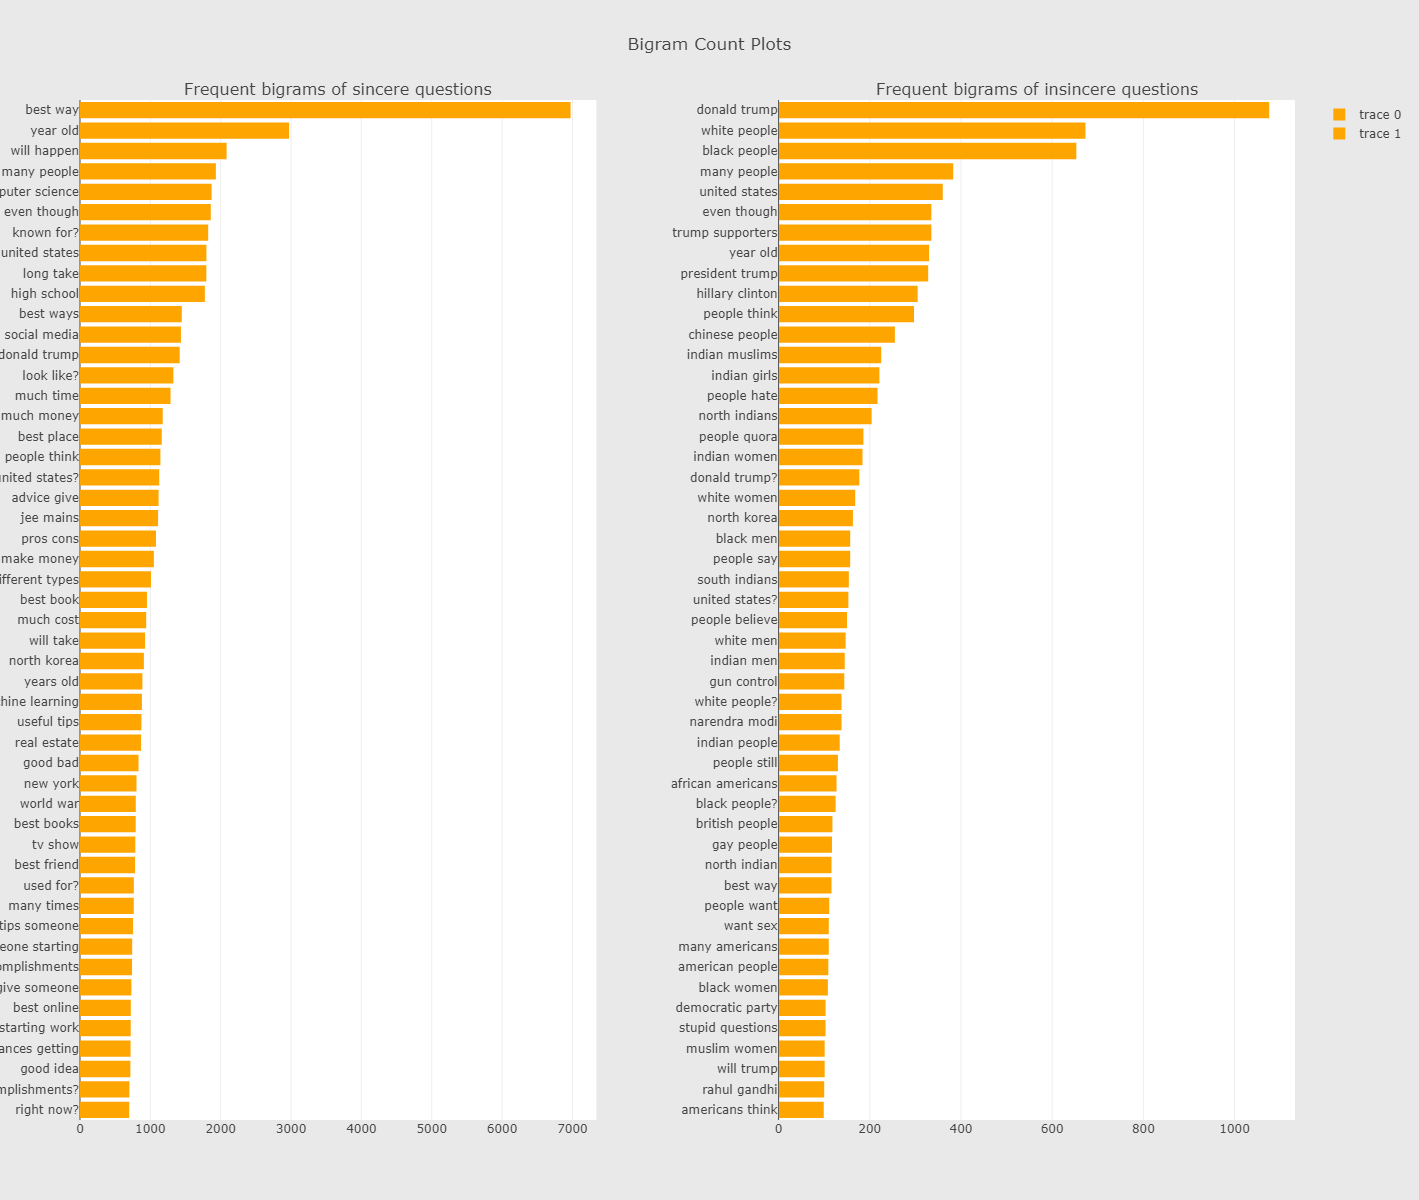

In [75]:
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.15,
                         subplot_titles=["Frequent bigrams of sincere questions",
                                        "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename="word-plots")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



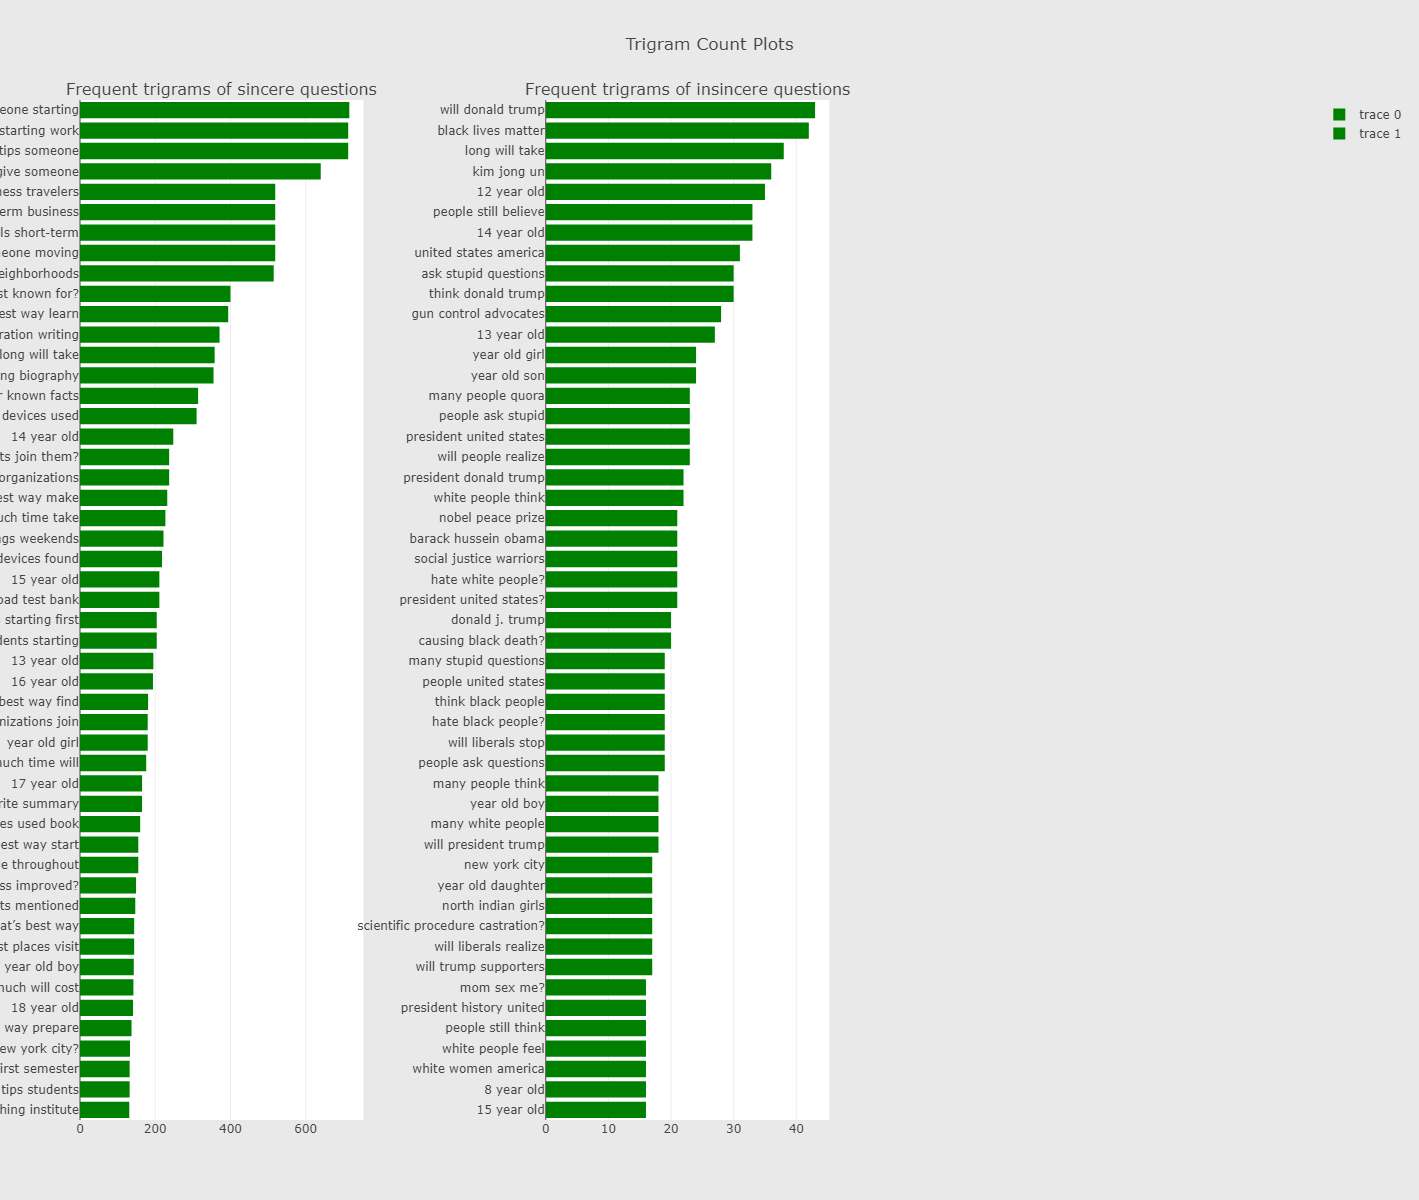

In [78]:
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, horizontal_spacing=0.15,
                         subplot_titles=["Frequent trigrams of sincere questions",
                                        "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename="word-plots")

In [7]:
## Feature Engineering ##
train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ## 
train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w in STOPWORDS ]))
test["num_stopwords"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w in STOPWORDS ]))

## Number of punctuations in the text ##
train["num_punctuations"] = train["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test["num_punctuations"] = test["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_lower"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))
test["num_words_lower"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

## Number of upper chars in the text ##
train["num_chars_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x) if w.isupper()]))
test["num_chars_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x) if w.isupper()]))

## Number of lower chars in the text ##
train["num_chars_lower"] = train["question_text"].apply(lambda x: len([w for w in str(x) if w.islower()]))
test["num_chars_lower"] = test["question_text"].apply(lambda x: len([w for w in str(x) if w.islower()]))

## Number of title case words in the text ##
train["num_words_title"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Max length of the words in the text ##
train["max_word_len"] = train["question_text"].apply(lambda x: np.max([len(w) for w in str(x).split()]))
test["max_word_len"] = test["question_text"].apply(lambda x: np.max([len(w) for w in str(x).split()]))

## Min length of the words in the text ##
train["min_word_len"] = train["question_text"].apply(lambda x: np.min([len(w) for w in str(x).split()]))
test["min_word_len"] = test["question_text"].apply(lambda x: np.min([len(w) for w in str(x).split()]))

In [ ]:
# The better written the code, the easier the copy pasta

# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]

def prepare_for_char_n_gram(text):
    """ Simple text clean up process"""
    # 1. Go to lower case (only good for english)
    # Go to bytes_strings as I had issues removing all \n in r""
    clean = bytes(text.lower(), encoding="utf-8")
    # 2. Drop \n and  \t
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    # 3. Replace english contractions
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    # 4. Drop puntuation
    # I could have used regex package with regex.sub(b"\p{P}", " ")
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    # 5. Drop numbers - as a scientist I don't think numbers are toxic ;-)
    clean = re.sub(b"\d+", b" ", clean)
    # 6. Remove extra spaces - At the end of previous operations we multiplied space accurences
    clean = re.sub(b'\s+', b' ', clean)
    # Remove ending space if any
    clean = re.sub(b'\s+$', b'', clean)
    # 7. Now replace words by words surrounded by # signs
    # e.g. my name is bond would become #my# #name# #is# #bond#
    # clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing #

    return str(clean, 'utf-8')

def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))

def get_indicators_and_clean_comments(df, text_var):
    """
    Check all sorts of content as it may help find toxic comment
    Though I'm not sure all of them improve scores
    """
    # Count number of \n
    df["ant_slash_n"] = df[text_var].apply(lambda x: count_regexp_occ(r"\n", x))
    # Get length in words and characters
    df["raw_word_len"] = df[text_var].apply(lambda x: len(x.split()))
    df["raw_char_len"] = df[text_var].apply(lambda x: len(x))
    # Check number of upper case, if you're angry you may write in upper case
    df["nb_upper"] = df[text_var].apply(lambda x: count_regexp_occ(r"[A-Z]", x))
    # Number of F words - f..k contains folk, fork,
    df["nb_fk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ff]\S{2}[Kk]", x))
    # Number of S word
    df["nb_sk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[Ss]\S{2}[Kk]", x))
    # Number of D words
    df["nb_dk"] = df[text_var].apply(lambda x: count_regexp_occ(r"[dD]ick", x))
    # Number of occurence of You, insulting someone usually needs someone called : you
    df["nb_you"] = df[text_var].apply(lambda x: count_regexp_occ(r"\W[Yy]ou\W", x))
    # Just to check you really refered to my mother ;-)
    df["nb_mother"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wmother\W", x))
    # Just checking for toxic 19th century vocabulary
    df["nb_ng"] = df[text_var].apply(lambda x: count_regexp_occ(r"\Wnigger\W", x))
    # Some Sentences start with a <:> so it may help
    df["start_with_columns"] = df[text_var].apply(lambda x: count_regexp_occ(r"^\:+", x))
    # Check for time stamp
    df["has_timestamp"] = df[text_var].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    # Check for dates 18:44, 8 December 2010
    df["has_date_long"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{2}:\d{2}, \d{1,2} \w+ \d{4}", x))
    # Check for date short 8 December 2010
    df["has_date_short"] = df[text_var].apply(lambda x: count_regexp_occ(r"\D\d{1,2} \w+ \d{4}", x))
    # Check for http links
    df["has_http"] = df[text_var].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    # check for mail
    df["has_mail"] = df[text_var].apply(
        lambda x: count_regexp_occ(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', x)
    )
    # Looking for words surrounded by == word == or """" word """"
    df["has_emphasize_equal"] = df[text_var].apply(lambda x: count_regexp_occ(r"\={2}.+\={2}", x))
    df["has_emphasize_quotes"] = df[text_var].apply(lambda x: count_regexp_occ(r"\"{4}\S+\"{4}", x))

    # Now clean comments
    df["clean_comment"] = df[text_var].apply(lambda x: prepare_for_char_n_gram(x))

    # Get the new length in words and characters
    df["clean_word_len"] = df["clean_comment"].apply(lambda x: len(x.split()))
    df["clean_char_len"] = df["clean_comment"].apply(lambda x: len(x))
    # Number of different characters used in a comment
    # Using the f word only will reduce the number of letters required in the comment
    df["clean_chars"] = df["clean_comment"].apply(lambda x: len(set(x)))
    df["clean_chars_ratio"] = df["clean_comment"].apply(lambda x: len(set(x))) / df["clean_comment"].apply(
        lambda x: 1 + min(99, len(x)))
    
def char_analyzer(text):
    """
    This is used to split strings in small lots
    I saw this in an article (I can't find the link anymore)
    so <talk> and <talking> would have <Tal> <alk> in common
    """
    tokens = text.split()
    return [token[i: i + 3] for token in tokens for i in range(len(token) - 2)]

all_text = pd.concat([train['question_text'],test['question_text']], axis =0)

word_vect = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w{1,}',
            stop_words='english',
            ngram_range=(1, 2),
            max_features=20000)

char_vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            strip_accents='unicode',
            tokenizer=char_analyzer,
            analyzer='word',
            ngram_range=(1, 1),
            max_features=50000)

with timer("Word Grams TFIDF"):
    word_vect.fit(all_text)
    train_word_features  = word_vect.transform(train['question_text'])
    test_word_features  = word_vect.transform(test['question_text'])

with timer("Character Grams TFIDF"):
    char_vectorizer.fit(all_text)
    train_char_features = char_vectorizer.transform(train['question_text'])
    test_char_features = char_vectorizer.transform(test['question_text'])

with timer("Performing basic NLP"):
    get_indicators_and_clean_comments(train, 'question_text')
    get_indicators_and_clean_comments(test,  'question_text')
    
    num_features = [f_ for f_ in train.columns
                if f_ not in ["question_text", "clean_comment", "remaining_chars",
                              'has_ip_address', 'target']]
    
# Get Sparse Matrix Feature Names..
feature_names = word_vect.get_feature_names() + char_vectorizer.get_feature_names() + num_features
del all_text; gc.collect()

with timer("Sparse Combine"):
    X = hstack(
        [
            train_char_features,
            train_word_features,
            train[num_features]
        ]
    ).tocsr()

    del train_char_features
    gc.collect()

    testing = hstack(
        [
            test_char_features,
            test_word_features,
            test[num_features]
        ]
    ).tocsr()
    del test_char_features; gc.collect()